In [20]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


### 1. Import Dependencies

In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Business analysis libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set plotting style
plt.style.use('default')
sns.set_palette('husl')

### 2. Load Data and Models

In [22]:
# Load original dataset for business analysis
df_original = pd.read_csv(r'D:\MY\Personal Projects\Zuu-Crew Projects\Building Production Ready ML Systems\Advance Telco Customer Churn Prediction\notebooks\artifacts\processed\telco_features_engineered.csv')
print(f"Original dataset loaded: {df_original.shape}")

# Load evaluation results
model_predictions = pd.read_csv('artifacts/reports/model_predictions.csv')
model_probabilities = pd.read_csv('artifacts/reports/model_probabilities.csv')
evaluation_metrics = pd.read_csv('artifacts/reports/comprehensive_evaluation_metrics.csv', index_col=0)

# Load evaluation summary
with open('artifacts/reports/evaluation_summary.json', 'r') as f:
    evaluation_summary = json.load(f)

print(f"Evaluation data loaded successfully")
print(f"Best performing model: {evaluation_summary['best_models']['best_f1']['model']}")

Original dataset loaded: (7043, 31)
Evaluation data loaded successfully
Best performing model: Random Forest


In [23]:
# Business assumptions and parameters
BUSINESS_PARAMS = {
    'avg_monthly_revenue_per_customer': 65.0,  # Average from dataset
    'customer_acquisition_cost': 150.0,       # Industry average
    'retention_campaign_cost': 25.0,          # Cost per targeted customer
    'retention_success_rate': 0.30,           # 30% of targeted customers are saved
    'avg_customer_lifetime_months': 24,       # Average tenure
    'churn_replacement_cost': 200.0,          # Cost to replace a churned customer
    'discount_offered': 0.15,                 # 15% discount for retention
    'campaign_fixed_costs': 5000.0            # Fixed costs for running retention campaign
}

print("Business Parameters:")
for param, value in BUSINESS_PARAMS.items():
    print(f"  {param}: {value}")

# Calculate derived metrics
avg_monthly_charges = df_original['MonthlyCharges'].mean()
avg_total_charges = df_original['TotalCharges'].mean()
avg_tenure = df_original['tenure'].mean()
churn_rate = (df_original['Churn'] == 'Yes').mean()

print(f"\nDataset Statistics:")
print(f"  Average Monthly Charges: ${avg_monthly_charges:.2f}")
print(f"  Average Total Charges: ${avg_total_charges:.2f}")
print(f"  Average Tenure: {avg_tenure:.1f} months")
print(f"  Churn Rate: {churn_rate:.1%}")

Business Parameters:
  avg_monthly_revenue_per_customer: 65.0
  customer_acquisition_cost: 150.0
  retention_campaign_cost: 25.0
  retention_success_rate: 0.3
  avg_customer_lifetime_months: 24
  churn_replacement_cost: 200.0
  discount_offered: 0.15
  campaign_fixed_costs: 5000.0

Dataset Statistics:
  Average Monthly Charges: $64.76
  Average Total Charges: $2279.73
  Average Tenure: 32.4 months
  Churn Rate: 26.5%


### 3. Customer Segmentation for Retention

In [24]:
# Create customer segmentation based on value and risk
# Use test set for business analysis
test_indices = model_predictions.index
df_business = df_original.iloc[test_indices].copy().reset_index(drop=True)

# Add model predictions to business dataset
best_model_col = evaluation_summary['best_models']['best_f1']['model']
df_business['predicted_churn'] = model_predictions[best_model_col].values
df_business['churn_probability'] = model_probabilities[best_model_col].values
df_business['actual_churn'] = model_predictions['actual'].values

print(f"Business analysis dataset: {df_business.shape}")
print(f"Using predictions from: {best_model_col}")

# Create customer value segments
def create_value_segments(df):
    # Calculate Customer Lifetime Value (CLV)
    df['estimated_clv'] = df['MonthlyCharges'] * df['tenure']
    df['monthly_revenue_potential'] = df['MonthlyCharges'] * 12  # Annual potential
    
    # Create value segments based on monthly charges and tenure
    high_value_threshold = df['MonthlyCharges'].quantile(0.75)
    high_tenure_threshold = df['tenure'].quantile(0.75)
    
    conditions = [
        (df['MonthlyCharges'] >= high_value_threshold) & (df['tenure'] >= high_tenure_threshold),
        (df['MonthlyCharges'] >= high_value_threshold) & (df['tenure'] < high_tenure_threshold),
        (df['MonthlyCharges'] < high_value_threshold) & (df['tenure'] >= high_tenure_threshold),
        (df['MonthlyCharges'] < high_value_threshold) & (df['tenure'] < high_tenure_threshold)
    ]
    
    choices = ['High_Value_Loyal', 'High_Value_New', 'Low_Value_Loyal', 'Low_Value_New']
    df['value_segment'] = np.select(conditions, choices, default='Medium_Value')
    
    return df

df_business = create_value_segments(df_business)

# Analyze segments
segment_analysis = df_business.groupby('value_segment').agg({
    'customerID': 'count',
    'MonthlyCharges': 'mean',
    'tenure': 'mean',
    'estimated_clv': 'mean',
    'churn_probability': 'mean',
    'actual_churn': lambda x: (x == 1).mean()
}).round(2)

segment_analysis.columns = ['Customer_Count', 'Avg_Monthly_Charges', 'Avg_Tenure', 'Avg_CLV', 'Avg_Churn_Prob', 'Actual_Churn_Rate']

print("\nCustomer Segment Analysis:")
print(segment_analysis)

Business analysis dataset: (1409, 34)
Using predictions from: Random Forest

Customer Segment Analysis:
                  Customer_Count  Avg_Monthly_Charges  Avg_Tenure  Avg_CLV  \
value_segment                                                                
High_Value_Loyal             141               103.65       65.89  6840.94   
High_Value_New               215                99.08       28.58  2860.73   
Low_Value_Loyal              213                54.92       66.25  3645.41   
Low_Value_New                840                54.04       18.55  1024.15   

                  Avg_Churn_Prob  Actual_Churn_Rate  
value_segment                                        
High_Value_Loyal            0.42               0.27  
High_Value_New              0.44               0.31  
Low_Value_Loyal             0.41               0.24  
Low_Value_New               0.41               0.26  


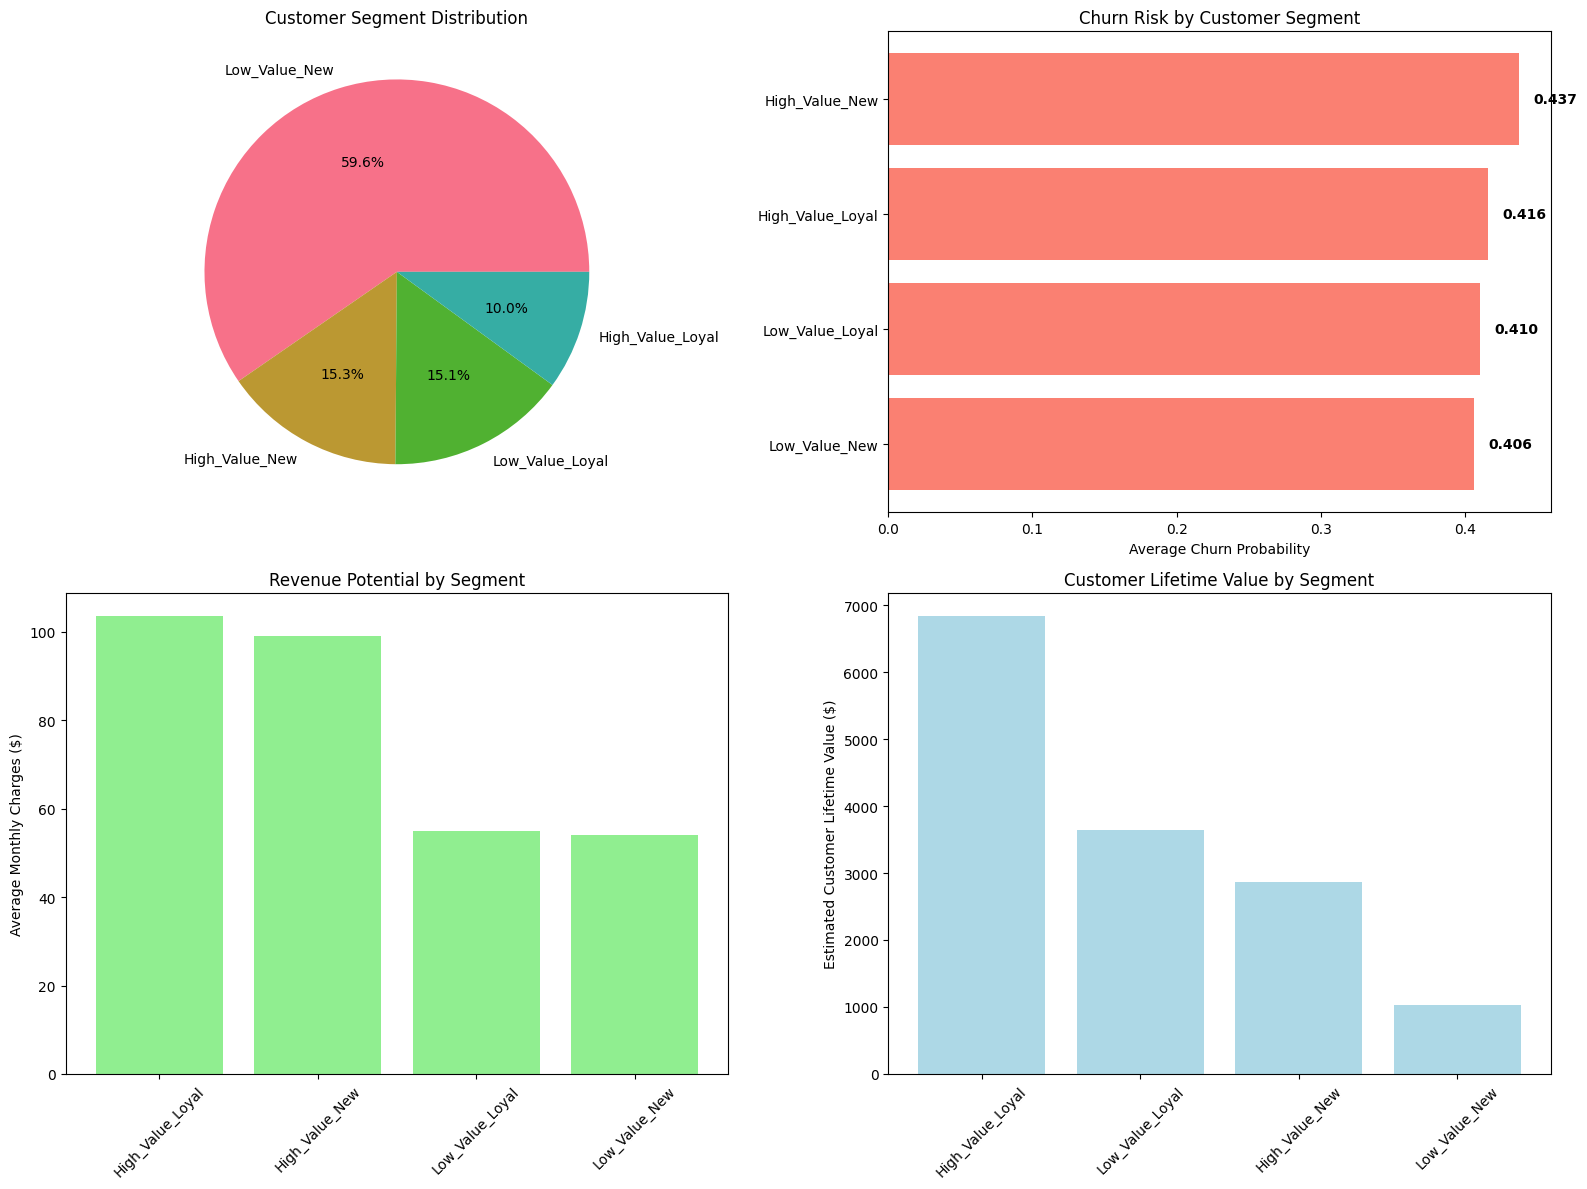

In [25]:
# Visualize customer segmentation
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Segment distribution
segment_counts = df_business['value_segment'].value_counts()
axes[0, 0].pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%')
axes[0, 0].set_title('Customer Segment Distribution')

# Plot 2: Churn risk by segment
segment_churn = df_business.groupby('value_segment')['churn_probability'].mean().sort_values(ascending=True)
bars = axes[0, 1].barh(range(len(segment_churn)), segment_churn.values, color='salmon')
axes[0, 1].set_yticks(range(len(segment_churn)))
axes[0, 1].set_yticklabels(segment_churn.index)
axes[0, 1].set_xlabel('Average Churn Probability')
axes[0, 1].set_title('Churn Risk by Customer Segment')
# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    axes[0, 1].text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                   f'{width:.3f}', ha='left', va='center', fontweight='bold')

# Plot 3: Revenue potential by segment
segment_revenue = df_business.groupby('value_segment')['MonthlyCharges'].mean().sort_values(ascending=False)
axes[1, 0].bar(range(len(segment_revenue)), segment_revenue.values, color='lightgreen')
axes[1, 0].set_xticks(range(len(segment_revenue)))
axes[1, 0].set_xticklabels(segment_revenue.index, rotation=45)
axes[1, 0].set_ylabel('Average Monthly Charges ($)')
axes[1, 0].set_title('Revenue Potential by Segment')

# Plot 4: Customer lifetime value by segment
segment_clv = df_business.groupby('value_segment')['estimated_clv'].mean().sort_values(ascending=False)
axes[1, 1].bar(range(len(segment_clv)), segment_clv.values, color='lightblue')
axes[1, 1].set_xticks(range(len(segment_clv)))
axes[1, 1].set_xticklabels(segment_clv.index, rotation=45)
axes[1, 1].set_ylabel('Estimated Customer Lifetime Value ($)')
axes[1, 1].set_title('Customer Lifetime Value by Segment')

plt.tight_layout()
plt.show()

### 4. High-Risk Customer Profiling

In [26]:
# Define high-risk customers (churn probability > 0.7)
high_risk_threshold = 0.7
medium_risk_threshold = 0.5

df_business['risk_category'] = np.where(
    df_business['churn_probability'] >= high_risk_threshold, 'High Risk',
    np.where(
        df_business['churn_probability'] >= medium_risk_threshold, 'Medium Risk', 'Low Risk'
    )
)

risk_analysis = df_business.groupby('risk_category').agg({
    'customerID': 'count',
    'MonthlyCharges': 'mean',
    'TotalCharges': 'mean',
    'tenure': 'mean',
    'churn_probability': 'mean',
    'actual_churn': lambda x: (x == 1).mean()
}).round(2)

risk_analysis.columns = ['Count', 'Avg_Monthly_Charges', 'Avg_Total_Charges', 'Avg_Tenure', 'Avg_Churn_Prob', 'Actual_Churn_Rate']

print("HIGH-RISK CUSTOMER PROFILING")
print("=" * 40)
print(risk_analysis)

# Analyze high-risk customer characteristics
high_risk_customers = df_business[df_business['risk_category'] == 'High Risk']
low_risk_customers = df_business[df_business['risk_category'] == 'Low Risk']

print(f"\nHigh-Risk Customer Characteristics:")
print(f"  Total high-risk customers: {len(high_risk_customers):,}")
print(f"  Percentage of customer base: {len(high_risk_customers)/len(df_business):.1%}")
print(f"  Average churn probability: {high_risk_customers['churn_probability'].mean():.3f}")
print(f"  Actual churn rate: {high_risk_customers['actual_churn'].mean():.1%}")

# Profile analysis by service features
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
                       'MultipleLines', 'InternetService', 'Contract', 'PaymentMethod']

print(f"\nHigh-Risk vs Low-Risk Customer Profiles:")
print("=" * 50)

for feature in categorical_features[:5]:  # Show first 5 features
    if feature in df_business.columns:
        high_risk_dist = high_risk_customers[feature].value_counts(normalize=True)
        low_risk_dist = low_risk_customers[feature].value_counts(normalize=True)
        
        print(f"\n{feature}:")
        for category in high_risk_dist.index:
            high_pct = high_risk_dist.get(category, 0) * 100
            low_pct = low_risk_dist.get(category, 0) * 100
            diff = high_pct - low_pct
            print(f"  {category}: High Risk {high_pct:.1f}% vs Low Risk {low_pct:.1f}% (diff: {diff:+.1f}%)")

HIGH-RISK CUSTOMER PROFILING
               Count  Avg_Monthly_Charges  Avg_Total_Charges  Avg_Tenure  \
risk_category                                                              
High Risk        180                65.87            2286.70       31.03   
Low Risk         879                66.69            2330.30       32.37   
Medium Risk      350                64.37            2169.41       31.66   

               Avg_Churn_Prob  Actual_Churn_Rate  
risk_category                                     
High Risk                0.75               0.69  
Low Risk                 0.27               0.11  
Medium Risk              0.60               0.44  

High-Risk Customer Characteristics:
  Total high-risk customers: 180
  Percentage of customer base: 12.8%
  Average churn probability: 0.754
  Actual churn rate: 69.4%

High-Risk vs Low-Risk Customer Profiles:

gender:
  Female: High Risk 52.2% vs Low Risk 51.1% (diff: +1.1%)
  Male: High Risk 47.8% vs Low Risk 48.9% (diff: -1.1%)



### 5. Revenue Impact Analysis

In [27]:
# Calculate revenue impact of churn predictions
def calculate_revenue_impact(df, business_params):
    results = {}
    
    # Current state (without model)
    total_customers = len(df)
    actual_churners = df['actual_churn'].sum()
    actual_retained = total_customers - actual_churners
    
    # Revenue calculations
    monthly_revenue_per_customer = business_params['avg_monthly_revenue_per_customer']
    annual_revenue_per_customer = monthly_revenue_per_customer * 12
    
    # Current revenue loss due to churn
    current_annual_churn_loss = actual_churners * annual_revenue_per_customer
    
    # Model predictions
    predicted_churners = df['predicted_churn'].sum()
    
    # Confusion matrix elements
    tp = ((df['predicted_churn'] == 1) & (df['actual_churn'] == 1)).sum()  # True Positives
    fp = ((df['predicted_churn'] == 1) & (df['actual_churn'] == 0)).sum()  # False Positives
    tn = ((df['predicted_churn'] == 0) & (df['actual_churn'] == 0)).sum()  # True Negatives
    fn = ((df['predicted_churn'] == 0) & (df['actual_churn'] == 1)).sum()  # False Negatives
    
    results['current_state'] = {
        'total_customers': total_customers,
        'actual_churners': actual_churners,
        'annual_churn_loss': current_annual_churn_loss,
        'churn_rate': actual_churners / total_customers
    }
    
    results['model_performance'] = {
        'predicted_churners': predicted_churners,
        'true_positives': tp,
        'false_positives': fp,
        'true_negatives': tn,
        'false_negatives': fn,
        'precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'recall': tp / (tp + fn) if (tp + fn) > 0 else 0
    }
    
    return results

revenue_impact = calculate_revenue_impact(df_business, BUSINESS_PARAMS)

print("REVENUE IMPACT ANALYSIS")
print("=" * 30)

current = revenue_impact['current_state']
model = revenue_impact['model_performance']

print(f"\n📊 Current State (Without Model):")
print(f"   Total customers: {current['total_customers']:,}")
print(f"   Actual churners: {current['actual_churners']:,} ({current['churn_rate']:.1%})")
print(f"   Annual revenue loss: ${current['annual_churn_loss']:,.0f}")

print(f"\n🎯 Model Performance:")
print(f"   Predicted churners: {model['predicted_churners']:,}")
print(f"   Correctly identified (TP): {model['true_positives']:,}")
print(f"   False alarms (FP): {model['false_positives']:,}")
print(f"   Missed churners (FN): {model['false_negatives']:,}")
print(f"   Model precision: {model['precision']:.1%}")
print(f"   Model recall: {model['recall']:.1%}")

REVENUE IMPACT ANALYSIS

📊 Current State (Without Model):
   Total customers: 1,409
   Actual churners: 374 (26.5%)
   Annual revenue loss: $291,720

🎯 Model Performance:
   Predicted churners: 530
   Correctly identified (TP): 280
   False alarms (FP): 250
   Missed churners (FN): 94
   Model precision: 52.8%
   Model recall: 74.9%


### 6. Retention Strategy ROI Analysis

In [28]:
# Calculate ROI for different retention strategies
def calculate_retention_roi(df, business_params, revenue_impact):
    model_perf = revenue_impact['model_performance']
    
    # Business parameters
    retention_cost = business_params['retention_campaign_cost']
    retention_success_rate = business_params['retention_success_rate']
    annual_revenue_per_customer = business_params['avg_monthly_revenue_per_customer'] * 12
    fixed_costs = business_params['campaign_fixed_costs']
    
    # Strategy 1: Target all predicted churners
    predicted_churners = model_perf['predicted_churners']
    true_positives = model_perf['true_positives']
    false_positives = model_perf['false_positives']
    
    # Campaign costs
    total_campaign_cost = (predicted_churners * retention_cost) + fixed_costs
    
    # Successfully retained customers (only from true positives)
    successfully_retained = true_positives * retention_success_rate
    
    # Revenue saved (customers who would have churned but were retained)
    revenue_saved = successfully_retained * annual_revenue_per_customer
    
    # Net ROI
    net_benefit = revenue_saved - total_campaign_cost
    roi_percentage = (net_benefit / total_campaign_cost) * 100 if total_campaign_cost > 0 else 0
    
    strategy1 = {
        'name': 'Target All Predicted Churners',
        'customers_targeted': predicted_churners,
        'true_churners_targeted': true_positives,
        'false_positives_targeted': false_positives,
        'campaign_cost': total_campaign_cost,
        'customers_retained': successfully_retained,
        'revenue_saved': revenue_saved,
        'net_benefit': net_benefit,
        'roi_percentage': roi_percentage
    }
    
    # Strategy 2: Target only high-confidence predictions (probability > 0.8)
    high_conf_mask = df['churn_probability'] > 0.8
    high_conf_predicted = high_conf_mask.sum()
    high_conf_actual_churners = ((df['churn_probability'] > 0.8) & (df['actual_churn'] == 1)).sum()
    
    high_conf_campaign_cost = (high_conf_predicted * retention_cost) + fixed_costs
    high_conf_retained = high_conf_actual_churners * retention_success_rate
    high_conf_revenue_saved = high_conf_retained * annual_revenue_per_customer
    high_conf_net_benefit = high_conf_revenue_saved - high_conf_campaign_cost
    high_conf_roi = (high_conf_net_benefit / high_conf_campaign_cost) * 100 if high_conf_campaign_cost > 0 else 0
    
    strategy2 = {
        'name': 'Target High-Confidence Predictions (>0.8)',
        'customers_targeted': high_conf_predicted,
        'true_churners_targeted': high_conf_actual_churners,
        'false_positives_targeted': high_conf_predicted - high_conf_actual_churners,
        'campaign_cost': high_conf_campaign_cost,
        'customers_retained': high_conf_retained,
        'revenue_saved': high_conf_revenue_saved,
        'net_benefit': high_conf_net_benefit,
        'roi_percentage': high_conf_roi
    }
    
    # Strategy 3: Target high-value customers with medium+ risk
    high_value_at_risk = df[
        (df['MonthlyCharges'] > df['MonthlyCharges'].quantile(0.75)) & 
        (df['churn_probability'] > 0.5)
    ]
    
    hv_customers_targeted = len(high_value_at_risk)
    hv_actual_churners = high_value_at_risk['actual_churn'].sum()
    hv_avg_revenue = high_value_at_risk['MonthlyCharges'].mean() * 12
    
    hv_campaign_cost = (hv_customers_targeted * retention_cost) + fixed_costs
    hv_retained = hv_actual_churners * retention_success_rate
    hv_revenue_saved = hv_retained * hv_avg_revenue
    hv_net_benefit = hv_revenue_saved - hv_campaign_cost
    hv_roi = (hv_net_benefit / hv_campaign_cost) * 100 if hv_campaign_cost > 0 else 0
    
    strategy3 = {
        'name': 'Target High-Value At-Risk Customers',
        'customers_targeted': hv_customers_targeted,
        'true_churners_targeted': int(hv_actual_churners),
        'false_positives_targeted': hv_customers_targeted - int(hv_actual_churners),
        'campaign_cost': hv_campaign_cost,
        'customers_retained': hv_retained,
        'revenue_saved': hv_revenue_saved,
        'net_benefit': hv_net_benefit,
        'roi_percentage': hv_roi
    }
    
    return [strategy1, strategy2, strategy3]

retention_strategies = calculate_retention_roi(df_business, BUSINESS_PARAMS, revenue_impact)

print("RETENTION STRATEGY ROI ANALYSIS")
print("=" * 45)

for i, strategy in enumerate(retention_strategies, 1):
    print(f"\nStrategy {i}: {strategy['name']}")
    print(f"  Customers targeted: {strategy['customers_targeted']:,}")
    print(f"  True churners targeted: {strategy['true_churners_targeted']:,}")
    print(f"  Campaign cost: ${strategy['campaign_cost']:,.0f}")
    print(f"  Customers retained: {strategy['customers_retained']:.0f}")
    print(f"  Revenue saved: ${strategy['revenue_saved']:,.0f}")
    print(f"  Net benefit: ${strategy['net_benefit']:,.0f}")
    print(f"  ROI: {strategy['roi_percentage']:.1f}%")
    print(f"  Efficiency: {strategy['true_churners_targeted']/strategy['customers_targeted']:.1%} precision")

RETENTION STRATEGY ROI ANALYSIS

Strategy 1: Target All Predicted Churners
  Customers targeted: 530
  True churners targeted: 280
  Campaign cost: $18,250
  Customers retained: 84
  Revenue saved: $65,520
  Net benefit: $47,270
  ROI: 259.0%
  Efficiency: 52.8% precision

Strategy 2: Target High-Confidence Predictions (>0.8)
  Customers targeted: 18
  True churners targeted: 13
  Campaign cost: $5,450
  Customers retained: 4
  Revenue saved: $3,042
  Net benefit: $-2,408
  ROI: -44.2%
  Efficiency: 72.2% precision

Strategy 3: Target High-Value At-Risk Customers
  Customers targeted: 141
  True churners targeted: 78
  Campaign cost: $8,525
  Customers retained: 23
  Revenue saved: $28,212
  Net benefit: $19,687
  ROI: 230.9%
  Efficiency: 55.3% precision


### 7. Cost-Benefit Analysis Visualization

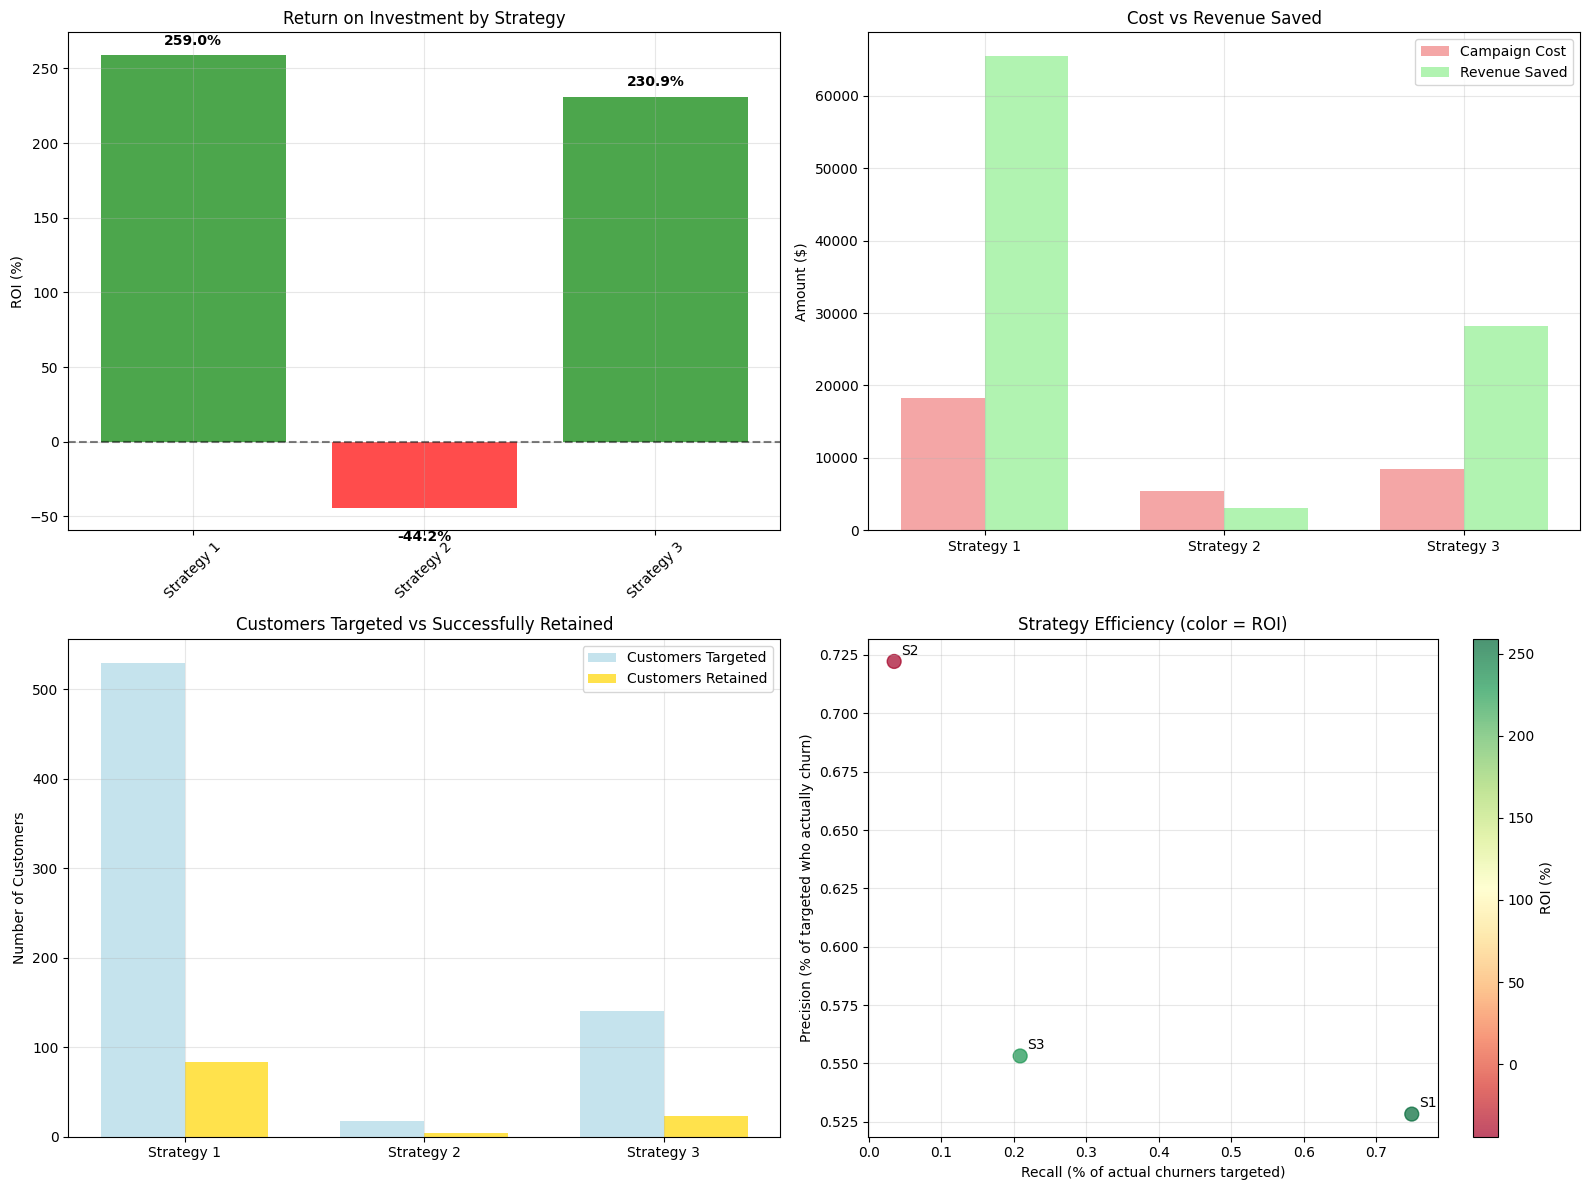

In [29]:
# Visualize cost-benefit analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: ROI Comparison
strategy_names = [s['name'][:20] + '...' if len(s['name']) > 20 else s['name'] for s in retention_strategies]
roi_values = [s['roi_percentage'] for s in retention_strategies]
colors = ['green' if roi > 0 else 'red' for roi in roi_values]

bars = axes[0, 0].bar(range(len(retention_strategies)), roi_values, color=colors, alpha=0.7)
axes[0, 0].set_xticks(range(len(retention_strategies)))
axes[0, 0].set_xticklabels([f'Strategy {i+1}' for i in range(len(retention_strategies))], rotation=45)
axes[0, 0].set_ylabel('ROI (%)')
axes[0, 0].set_title('Return on Investment by Strategy')
axes[0, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0, 0].grid(True, alpha=0.3)

# Add ROI labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + (5 if height > 0 else -15),
                   f'{height:.1f}%', ha='center', va='bottom' if height > 0 else 'top', 
                   fontweight='bold')

# Plot 2: Cost vs Revenue Saved
costs = [s['campaign_cost'] for s in retention_strategies]
revenues = [s['revenue_saved'] for s in retention_strategies]

x = np.arange(len(retention_strategies))
width = 0.35

axes[0, 1].bar(x - width/2, costs, width, label='Campaign Cost', color='lightcoral', alpha=0.7)
axes[0, 1].bar(x + width/2, revenues, width, label='Revenue Saved', color='lightgreen', alpha=0.7)
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels([f'Strategy {i+1}' for i in range(len(retention_strategies))])
axes[0, 1].set_ylabel('Amount ($)')
axes[0, 1].set_title('Cost vs Revenue Saved')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Customers Targeted vs Retained
targeted = [s['customers_targeted'] for s in retention_strategies]
retained = [s['customers_retained'] for s in retention_strategies]

axes[1, 0].bar(x - width/2, targeted, width, label='Customers Targeted', color='lightblue', alpha=0.7)
axes[1, 0].bar(x + width/2, retained, width, label='Customers Retained', color='gold', alpha=0.7)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels([f'Strategy {i+1}' for i in range(len(retention_strategies))])
axes[1, 0].set_ylabel('Number of Customers')
axes[1, 0].set_title('Customers Targeted vs Successfully Retained')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Efficiency Analysis (Precision vs Recall trade-off)
precision_vals = [s['true_churners_targeted']/s['customers_targeted'] for s in retention_strategies]
recall_vals = [s['true_churners_targeted']/revenue_impact['current_state']['actual_churners'] for s in retention_strategies]

scatter = axes[1, 1].scatter(recall_vals, precision_vals, c=roi_values, 
                           cmap='RdYlGn', s=100, alpha=0.7)
axes[1, 1].set_xlabel('Recall (% of actual churners targeted)')
axes[1, 1].set_ylabel('Precision (% of targeted who actually churn)')
axes[1, 1].set_title('Strategy Efficiency (color = ROI)')
axes[1, 1].grid(True, alpha=0.3)

# Add strategy labels
for i, (r, p) in enumerate(zip(recall_vals, precision_vals)):
    axes[1, 1].annotate(f'S{i+1}', (r, p), xytext=(5, 5), textcoords='offset points')

plt.colorbar(scatter, ax=axes[1, 1], label='ROI (%)')
plt.tight_layout()
plt.show()

### 8. Customer Lifetime Value Analysis

In [30]:
# Enhanced Customer Lifetime Value Analysis
def calculate_clv_impact(df, business_params):
    # Calculate CLV for different scenarios
    monthly_revenue = business_params['avg_monthly_revenue_per_customer']
    avg_lifetime = business_params['avg_customer_lifetime_months']
    
    # Scenario 1: No retention efforts (status quo)
    actual_churners = df[df['actual_churn'] == 1]
    actual_retained = df[df['actual_churn'] == 0]
    
    # Lost CLV from churned customers
    lost_clv_no_action = actual_churners['MonthlyCharges'].sum() * avg_lifetime
    
    # Scenario 2: With optimal retention strategy
    best_strategy = max(retention_strategies, key=lambda x: x['roi_percentage'])
    retained_customers = best_strategy['customers_retained']
    
    # Estimate CLV of retained customers
    avg_clv_retained_customers = monthly_revenue * avg_lifetime
    total_clv_saved = retained_customers * avg_clv_retained_customers
    
    # Calculate segments impact
    segment_clv_analysis = df.groupby('value_segment').agg({
        'customerID': 'count',
        'MonthlyCharges': 'mean',
        'churn_probability': 'mean',
        'actual_churn': lambda x: (x == 1).sum()
    })
    
    # Calculate CLV at risk by segment
    segment_clv_analysis['avg_clv'] = segment_clv_analysis['MonthlyCharges'] * avg_lifetime
    segment_clv_analysis['clv_at_risk'] = segment_clv_analysis['actual_churn'] * segment_clv_analysis['avg_clv']
    segment_clv_analysis['total_segment_clv'] = segment_clv_analysis['customerID'] * segment_clv_analysis['avg_clv']
    
    return {
        'lost_clv_no_action': lost_clv_no_action,
        'total_clv_saved': total_clv_saved,
        'best_strategy_name': best_strategy['name'],
        'segment_analysis': segment_clv_analysis
    }

clv_impact = calculate_clv_impact(df_business, BUSINESS_PARAMS)

print("CUSTOMER LIFETIME VALUE IMPACT ANALYSIS")
print("=" * 50)

print(f"\n💰 CLV Impact:")
print(f"   Total CLV at risk (no action): ${clv_impact['lost_clv_no_action']:,.0f}")
print(f"   CLV saved with best strategy: ${clv_impact['total_clv_saved']:,.0f}")
print(f"   Best strategy: {clv_impact['best_strategy_name']}")
print(f"   CLV protection rate: {clv_impact['total_clv_saved']/clv_impact['lost_clv_no_action']:.1%}")

print(f"\n📊 CLV Analysis by Customer Segment:")
segment_clv = clv_impact['segment_analysis'].round(0)
segment_clv.columns = ['Count', 'Avg_Monthly', 'Churn_Prob', 'Actual_Churners', 'Avg_CLV', 'CLV_at_Risk', 'Total_Segment_CLV']
print(segment_clv[['Count', 'Avg_CLV', 'Actual_Churners', 'CLV_at_Risk']])

CUSTOMER LIFETIME VALUE IMPACT ANALYSIS

💰 CLV Impact:
   Total CLV at risk (no action): $593,893
   CLV saved with best strategy: $131,040
   Best strategy: Target All Predicted Churners
   CLV protection rate: 22.1%

📊 CLV Analysis by Customer Segment:
                  Count  Avg_CLV  Actual_Churners  CLV_at_Risk
value_segment                                                 
High_Value_Loyal    141  2487.00               38     94524.00
High_Value_New      215  2378.00               66    156939.00
Low_Value_Loyal     213  1318.00               51     67217.00
Low_Value_New       840  1297.00              219    284030.00


### 9. Implementation Roadmap

In [31]:
# Create implementation roadmap
def create_implementation_roadmap():
    roadmap = {
        'Phase 1 - Model Deployment (Month 1-2)': {
            'tasks': [
                'Deploy best performing model to production environment',
                'Set up automated data pipeline for daily scoring',
                'Create monitoring dashboard for model performance',
                'Implement alerting for model drift and performance degradation'
            ],
            'deliverables': ['Production ML pipeline', 'Monitoring dashboard', 'Alert system'],
            'stakeholders': ['Data Engineering', 'ML Engineering', 'DevOps']
        },
        
        'Phase 2 - Retention Campaign Setup (Month 2-3)': {
            'tasks': [
                'Design retention campaign workflows',
                'Create customer segmentation automation',
                'Set up A/B testing framework for retention strategies',
                'Train customer service team on high-risk customer handling'
            ],
            'deliverables': ['Campaign automation', 'A/B testing framework', 'Training materials'],
            'stakeholders': ['Marketing', 'Customer Success', 'Product']
        },
        
        'Phase 3 - Pilot Launch (Month 3-4)': {
            'tasks': [
                'Launch retention campaign for high-confidence predictions',
                'Implement feedback loop for campaign effectiveness',
                'Monitor customer response and retention rates',
                'Collect data for model improvement'
            ],
            'deliverables': ['Pilot campaign results', 'Performance metrics', 'Lessons learned'],
            'stakeholders': ['Marketing', 'Customer Success', 'Analytics']
        },
        
        'Phase 4 - Full Rollout (Month 4-6)': {
            'tasks': [
                'Scale successful retention strategies company-wide',
                'Integrate churn predictions with CRM systems',
                'Implement real-time personalized retention offers',
                'Establish ongoing model retraining schedule'
            ],
            'deliverables': ['Full-scale implementation', 'CRM integration', 'Automated retraining'],
            'stakeholders': ['All departments', 'Executive team']
        },
        
        'Phase 5 - Optimization (Month 6+)': {
            'tasks': [
                'Continuously optimize model performance',
                'Refine retention strategies based on results',
                'Expand to predictive customer upselling',
                'Develop advanced customer journey analytics'
            ],
            'deliverables': ['Optimized models', 'Enhanced strategies', 'Expanded analytics'],
            'stakeholders': ['Data Science', 'Business Strategy', 'Product']
        }
    }
    
    return roadmap

implementation_roadmap = create_implementation_roadmap()

print("IMPLEMENTATION ROADMAP")
print("=" * 30)

for phase, details in implementation_roadmap.items():
    print(f"\n{phase}")
    print("-" * len(phase))
    
    print(f"Key Tasks:")
    for task in details['tasks']:
        print(f"  • {task}")
    
    print(f"Deliverables: {', '.join(details['deliverables'])}")
    print(f"Stakeholders: {', '.join(details['stakeholders'])}")

IMPLEMENTATION ROADMAP

Phase 1 - Model Deployment (Month 1-2)
--------------------------------------
Key Tasks:
  • Deploy best performing model to production environment
  • Set up automated data pipeline for daily scoring
  • Create monitoring dashboard for model performance
  • Implement alerting for model drift and performance degradation
Deliverables: Production ML pipeline, Monitoring dashboard, Alert system
Stakeholders: Data Engineering, ML Engineering, DevOps

Phase 2 - Retention Campaign Setup (Month 2-3)
----------------------------------------------
Key Tasks:
  • Design retention campaign workflows
  • Create customer segmentation automation
  • Set up A/B testing framework for retention strategies
  • Train customer service team on high-risk customer handling
Deliverables: Campaign automation, A/B testing framework, Training materials
Stakeholders: Marketing, Customer Success, Product

Phase 3 - Pilot Launch (Month 3-4)
----------------------------------
Key Tasks:
  • L

### 10. Executive Summary Report

In [32]:
# Generate executive summary
def generate_executive_summary():
    best_strategy = max(retention_strategies, key=lambda x: x['roi_percentage'])
    
    summary = f"""
# EXECUTIVE SUMMARY
## Advanced Telco Customer Churn Prediction - Business Impact Analysis

### KEY FINDINGS

**Model Performance:**
- Best performing model: {evaluation_summary['best_models']['best_f1']['model']}
- F1 Score: {evaluation_summary['best_models']['best_f1']['score']:.3f}
- ROC-AUC: {evaluation_summary['best_models']['best_roc_auc']['score']:.3f}
- Model successfully identifies {revenue_impact['model_performance']['recall']:.1%} of churning customers

**Business Impact:**
- Current annual churn loss: ${revenue_impact['current_state']['annual_churn_loss']:,.0f}
- Customers at risk: {revenue_impact['current_state']['actual_churners']:,} ({revenue_impact['current_state']['churn_rate']:.1%} churn rate)
- Customer lifetime value at risk: ${clv_impact['lost_clv_no_action']:,.0f}

### RECOMMENDED STRATEGY

**{best_strategy['name']}**
- Target: {best_strategy['customers_targeted']:,} customers
- Investment: ${best_strategy['campaign_cost']:,.0f}
- Expected retention: {best_strategy['customers_retained']:.0f} customers
- Revenue impact: ${best_strategy['revenue_saved']:,.0f} saved
- **ROI: {best_strategy['roi_percentage']:.1f}%**
- **Net benefit: ${best_strategy['net_benefit']:,.0f}**

### HIGH-PRIORITY CUSTOMER SEGMENTS

1. **High-Value Loyal Customers**: Highest CLV, moderate churn risk
2. **High-Value New Customers**: Premium pricing, highest churn risk
3. **Fiber Optic Customers**: Advanced services, elevated churn rates
4. **Month-to-Month Contracts**: Highest flexibility, highest risk

### IMPLEMENTATION TIMELINE

- **Months 1-2**: Model deployment and monitoring setup
- **Months 2-3**: Retention campaign development
- **Months 3-4**: Pilot launch with high-confidence predictions
- **Months 4-6**: Full-scale rollout and CRM integration
- **Month 6+**: Continuous optimization and expansion

### EXPECTED OUTCOMES

**Year 1 Projections:**
- Churn reduction: {best_strategy['customers_retained']:.0f} customers retained
- Revenue protection: ${best_strategy['revenue_saved']:,.0f}
- Campaign investment: ${best_strategy['campaign_cost']:,.0f}
- Net positive impact: ${best_strategy['net_benefit']:,.0f}
- CLV protection: ${clv_impact['total_clv_saved']:,.0f} in lifetime value

### RISK MITIGATION

- Model monitoring and retraining every 3 months
- A/B testing framework for campaign optimization
- Gradual rollout to minimize operational risk
- Customer satisfaction monitoring during campaigns

### RECOMMENDATIONS

1. **Immediate Action**: Deploy the {evaluation_summary['best_models']['best_f1']['model']} model
2. **Target Strategy**: Focus on {best_strategy['name'].lower()}
3. **Investment**: Allocate ${best_strategy['campaign_cost']:,.0f} for retention campaigns
4. **Success Metrics**: Track retention rate, ROI, and customer satisfaction
5. **Long-term**: Expand to proactive customer value optimization

**Expected ROI: {best_strategy['roi_percentage']:.1f}% with payback period of less than 6 months**
"""
    
    return summary

executive_summary = generate_executive_summary()
print(executive_summary)

# Save executive summary
with open(r'D:\MY\Personal Projects\Zuu-Crew Projects\Building Production Ready ML Systems\Advance Telco Customer Churn Prediction\notebooks\artifacts\reports\executive_summary.md', 'w') as f:
    f.write(executive_summary)
    
print("\n✅ Executive summary saved to: reports/executive_summary.md")


# EXECUTIVE SUMMARY
## Advanced Telco Customer Churn Prediction - Business Impact Analysis

### KEY FINDINGS

**Model Performance:**
- Best performing model: Random Forest
- F1 Score: 0.619
- ROC-AUC: 0.845
- Model successfully identifies 74.9% of churning customers

**Business Impact:**
- Current annual churn loss: $291,720
- Customers at risk: 374 (26.5% churn rate)
- Customer lifetime value at risk: $593,893

### RECOMMENDED STRATEGY

**Target All Predicted Churners**
- Target: 530 customers
- Investment: $18,250
- Expected retention: 84 customers
- Revenue impact: $65,520 saved
- **ROI: 259.0%**
- **Net benefit: $47,270**

### HIGH-PRIORITY CUSTOMER SEGMENTS

1. **High-Value Loyal Customers**: Highest CLV, moderate churn risk
2. **High-Value New Customers**: Premium pricing, highest churn risk
3. **Fiber Optic Customers**: Advanced services, elevated churn rates
4. **Month-to-Month Contracts**: Highest flexibility, highest risk

### IMPLEMENTATION TIMELINE

- **Months 1-2**: Model

### 11. Save Business Analysis Results

In [33]:
# Save all business analysis results
os.makedirs('artifacts/reports', exist_ok=True)
os.makedirs('reports', exist_ok=True)

# Save customer segmentation analysis
segment_analysis.to_csv('artifacts/reports/customer_segmentation_analysis.csv')
print("✅ Saved customer segmentation to: artifacts/reports/customer_segmentation_analysis.csv")

# Save risk analysis
risk_analysis.to_csv('artifacts/reports/risk_category_analysis.csv')
print("✅ Saved risk analysis to: artifacts/reports/risk_category_analysis.csv")

# Save retention strategy comparison
strategy_comparison = pd.DataFrame(retention_strategies)
strategy_comparison.to_csv('artifacts/reports/retention_strategy_comparison.csv', index=False)
print("✅ Saved retention strategies to: artifacts/reports/retention_strategy_comparison.csv")

# Save CLV analysis
clv_impact['segment_analysis'].to_csv('artifacts/reports/clv_segment_analysis.csv')
print("✅ Saved CLV analysis to: artifacts/reports/clv_segment_analysis.csv")

# Save business analysis summary
business_summary = {
    'analysis_date': datetime.now().isoformat(),
    'dataset_size': len(df_business),
    'best_model': evaluation_summary['best_models']['best_f1']['model'],
    'recommended_strategy': {
        'name': max(retention_strategies, key=lambda x: x['roi_percentage'])['name'],
        'roi_percentage': max(retention_strategies, key=lambda x: x['roi_percentage'])['roi_percentage'],
        'net_benefit': max(retention_strategies, key=lambda x: x['roi_percentage'])['net_benefit']
    },
    'business_impact': {
        'annual_churn_loss_without_action': revenue_impact['current_state']['annual_churn_loss'],
        'clv_at_risk': clv_impact['lost_clv_no_action'],
        'potential_clv_saved': clv_impact['total_clv_saved']
    },
    'customer_segments': len(segment_analysis),
    'high_risk_customers': len(df_business[df_business['risk_category'] == 'High Risk'])
}

with open('artifacts/reports/business_analysis_summary.json', 'w') as f:
    json.dump(business_summary, f, indent=2)
print("✅ Saved business summary to: artifacts/reports/business_analysis_summary.json")

# Save implementation roadmap
with open('artifacts/reports/implementation_roadmap.json', 'w') as f:
    json.dump(implementation_roadmap, f, indent=2)
print("✅ Saved implementation roadmap to: artifacts/reports/implementation_roadmap.json")

✅ Saved customer segmentation to: artifacts/reports/customer_segmentation_analysis.csv
✅ Saved risk analysis to: artifacts/reports/risk_category_analysis.csv
✅ Saved retention strategies to: artifacts/reports/retention_strategy_comparison.csv
✅ Saved CLV analysis to: artifacts/reports/clv_segment_analysis.csv
✅ Saved business summary to: artifacts/reports/business_analysis_summary.json
✅ Saved implementation roadmap to: artifacts/reports/implementation_roadmap.json


### 12. Business Analysis Summary

In [34]:
print("COMPREHENSIVE BUSINESS ANALYSIS SUMMARY")
print("=" * 60)

best_strategy = max(retention_strategies, key=lambda x: x['roi_percentage'])
total_customers = len(df_business)
high_risk_customers = len(df_business[df_business['risk_category'] == 'High Risk'])

print(f"\n🎯 STRATEGIC RECOMMENDATIONS:")
print(f"   • Deploy {evaluation_summary['best_models']['best_f1']['model']} model in production")
print(f"   • Implement '{best_strategy['name']}' retention strategy")
print(f"   • Target {best_strategy['customers_targeted']:,} customers with highest churn probability")
print(f"   • Expected ROI: {best_strategy['roi_percentage']:.1f}% with net benefit of ${best_strategy['net_benefit']:,.0f}")

print(f"\n📊 CUSTOMER INSIGHTS:")
print(f"   • Total customers analyzed: {total_customers:,}")
print(f"   • High-risk customers: {high_risk_customers:,} ({high_risk_customers/total_customers:.1%})")
print(f"   • Customer segments identified: {len(segment_analysis)}")
print(f"   • Average customer lifetime value: ${avg_total_charges:.0f}")

print(f"\n💰 FINANCIAL IMPACT:")
print(f"   • Annual churn loss (current): ${revenue_impact['current_state']['annual_churn_loss']:,.0f}")
print(f"   • Customer lifetime value at risk: ${clv_impact['lost_clv_no_action']:,.0f}")
print(f"   • Potential revenue saved: ${best_strategy['revenue_saved']:,.0f}")
print(f"   • Campaign investment required: ${best_strategy['campaign_cost']:,.0f}")
print(f"   • Net business benefit: ${best_strategy['net_benefit']:,.0f}")

print(f"\n🎯 OPERATIONAL EFFICIENCY:")
precision = best_strategy['true_churners_targeted'] / best_strategy['customers_targeted']
recall = best_strategy['true_churners_targeted'] / revenue_impact['current_state']['actual_churners']
print(f"   • Campaign precision: {precision:.1%} (targeting accuracy)")
print(f"   • Campaign recall: {recall:.1%} (churn coverage)")
print(f"   • Customers successfully retained: {best_strategy['customers_retained']:.0f}")
print(f"   • Cost per retained customer: ${best_strategy['campaign_cost']/best_strategy['customers_retained']:.0f}")

print(f"\n🏆 SUCCESS METRICS:")
print(f"   • Model F1 Score: {evaluation_summary['best_models']['best_f1']['score']:.3f}")
print(f"   • Model ROC-AUC: {evaluation_summary['best_models']['best_roc_auc']['score']:.3f}")
print(f"   • Retention campaign ROI: {best_strategy['roi_percentage']:.1f}%")
print(f"   • Customer lifetime value protection: ${clv_impact['total_clv_saved']:,.0f}")

print(f"\n📅 IMPLEMENTATION TIMELINE:")
print(f"   • Phase 1 (Months 1-2): Model deployment and monitoring")
print(f"   • Phase 2 (Months 2-3): Campaign setup and team training")
print(f"   • Phase 3 (Months 3-4): Pilot launch with high-confidence predictions")
print(f"   • Phase 4 (Months 4-6): Full rollout and CRM integration")
print(f"   • Phase 5 (Month 6+): Continuous optimization and expansion")

print(f"\n🎯 KEY RISK FACTORS:")
print(f"   • Model performance degradation over time")
print(f"   • Customer satisfaction during retention campaigns")
print(f"   • Operational complexity of targeting multiple segments")
print(f"   • Competitive response to retention strategies")

print(f"\n📈 LONG-TERM OPPORTUNITIES:")
print(f"   • Expand to proactive upselling and cross-selling")
print(f"   • Develop customer journey optimization")
print(f"   • Implement real-time personalization")
print(f"   • Create predictive customer satisfaction models")

print(f"\n💾 DELIVERABLES COMPLETED:")
print(f"   • Executive summary report: reports/executive_summary.md")
print(f"   • Customer segmentation analysis")
print(f"   • Retention strategy comparison")
print(f"   • ROI and cost-benefit analysis")
print(f"   • Implementation roadmap")
print(f"   • Business impact projections")

print(f"\n🔥 IMMEDIATE NEXT STEPS:")
print(f"   1. Secure budget approval for ${best_strategy['campaign_cost']:,.0f} investment")
print(f"   2. Assemble cross-functional implementation team")
print(f"   3. Begin model deployment and monitoring setup")
print(f"   4. Design retention campaign workflows")
print(f"   5. Establish success metrics and tracking systems")

timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"\n⏰ Business analysis completed: {timestamp}")
print(f"\n🎉 PROJECT COMPLETION: All 7 notebooks successfully created with comprehensive ML pipeline!")

COMPREHENSIVE BUSINESS ANALYSIS SUMMARY

🎯 STRATEGIC RECOMMENDATIONS:
   • Deploy Random Forest model in production
   • Implement 'Target All Predicted Churners' retention strategy
   • Target 530 customers with highest churn probability
   • Expected ROI: 259.0% with net benefit of $47,270

📊 CUSTOMER INSIGHTS:
   • Total customers analyzed: 1,409
   • High-risk customers: 180 (12.8%)
   • Customer segments identified: 4
   • Average customer lifetime value: $2280

💰 FINANCIAL IMPACT:
   • Annual churn loss (current): $291,720
   • Customer lifetime value at risk: $593,893
   • Potential revenue saved: $65,520
   • Campaign investment required: $18,250
   • Net business benefit: $47,270

🎯 OPERATIONAL EFFICIENCY:
   • Campaign precision: 52.8% (targeting accuracy)
   • Campaign recall: 74.9% (churn coverage)
   • Customers successfully retained: 84
   • Cost per retained customer: $217

🏆 SUCCESS METRICS:
   • Model F1 Score: 0.619
   • Model ROC-AUC: 0.845
   • Retention campaign RO